In [1]:
import scanpy as sc
import torch 
from torch.utils import data
import torch.optim as optim

In [2]:
from scInferCode.utils import screen_candidate
from scInferCode.utils import add_cluster_info
from scInferCode.utils import make_infer_dataset
from scInferCode.model import InferNetwork, ClusterLoss
from scInferCode.utils import train_infer
from scInferCode.utils import infer_protein

In [3]:
rna = sc.read_h5ad('./scInferData/BreastTask/rna.h5ad')
protein = sc.read_h5ad('./scInferData/BreastTask/protein.h5ad')

In [4]:
rna_em = sc.read_h5ad('./scInferData/BreastTask/rna_embeddings.h5ad')
protein_em = sc.read_h5ad('./scInferData/BreastTask/protein_embeddings.h5ad')

In [5]:
threshold = 0.75
min_prt_num = 3
screen_num = 20
temperature = 3

In [6]:
candidate_df, black_list = screen_candidate(rna_em, protein_em, threshold, screen_num, min_prt_num)

There are 16 rna cells cannot find candidate protein cells.


In [7]:
rna = rna[~rna.obs_names.isin(black_list)]

In [8]:
rna.obs = rna.obs.merge(candidate_df[[f'match_{screen_num}_largest']], left_index=True, right_index=True, how='left')

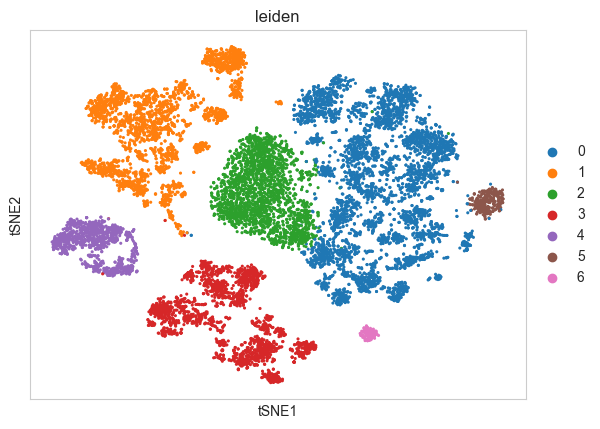

In [17]:
rna_hv = add_cluster_info(rna, resolution=0.1, cluster_by='highly_variable')

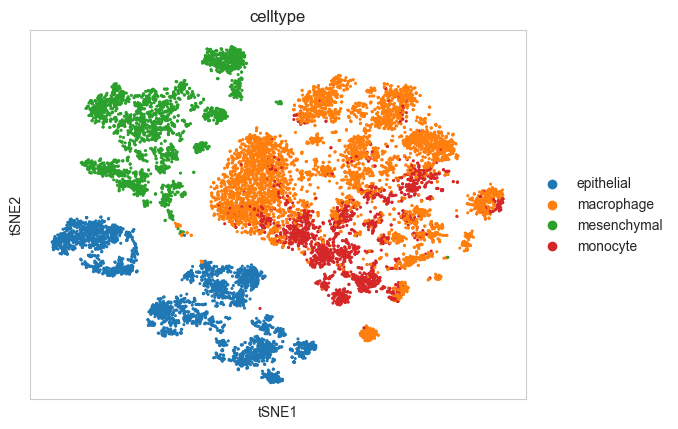

In [18]:
sc.pl.tsne(rna_hv, color='celltype', size=20)

In [19]:
match_list_df, protein_df, train_dataset, test_dataset = make_infer_dataset(rna_hv, screen_num, protein, valid_ratio=0.3)

/media/yuzhi/Data/scInfer_for_submit/scInfer/scInferCode/utils.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ids.groupby(by)


In [20]:
input_size = train_dataset.get_size() 
batch_size = 2048
num_epochs = 40
lr = 0.5
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)
criterion = ClusterLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False)

Training: 100%|██████████| 40/40 [02:18<00:00,  3.47s/epoch, train_loss=0.0256904084, test_loss=0.7056370622, lr=0.328050]


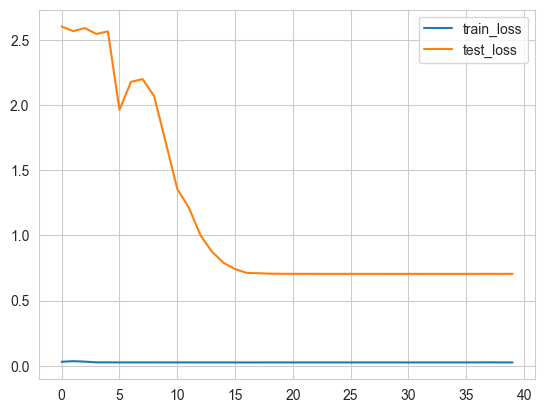

In [22]:
model = train_infer(train_loader, test_loader, model, criterion, num_epochs, patience, optimizer, batch_size, device, plot_line=True)

In [50]:
model_path = f'./scInferData/BreastTask/BreastTaskInfer.pth'
# torch.save(model.state_dict(), model_path)

In [51]:
model = InferNetwork(input_size,output_size=screen_num, t=temperature).to(device)

In [52]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [53]:
model.eval()

InferNetwork(
  (features): Sequential(
    (0): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1408, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [54]:
rna_res = infer_protein(protein_df, match_list_df, device, model, protein, rna, screen_num)

In [55]:
rna_res.write('./scInferData/BreastTask/breast_all_final_inference.h5ad')

In [56]:
infer_res = sc.read_h5ad('./scInferData/BreastTask/breast_all_final_inference.h5ad')

In [57]:
rna_ann = infer_res

In [58]:
rna_ann_hv = rna_ann[:,rna_ann.var['highly_variable']]

In [59]:
sc.pp.pca(rna_ann_hv)
sc.tl.tsne(rna_ann_hv)

/home/yuzhi/.conda/envs/scInfer/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


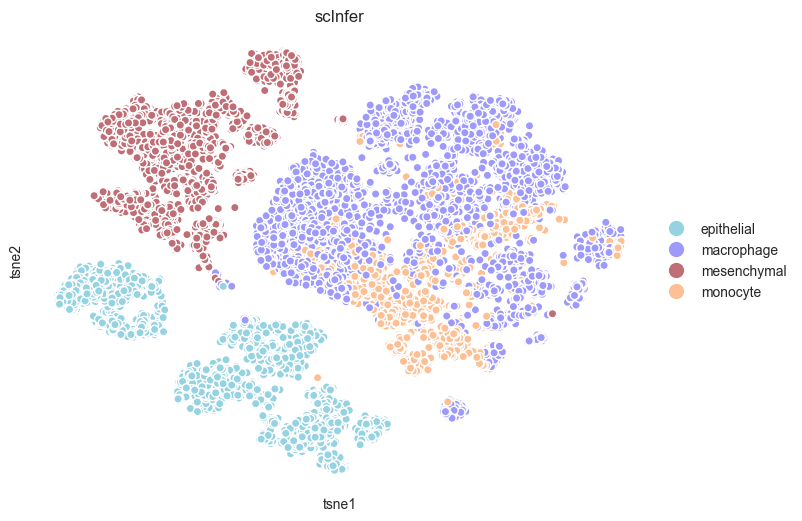

In [60]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# 合并数据用于 t-SNE 绘图  
data = rna_ann_hv.obs.merge(  
    pd.DataFrame(  
        rna_ann_hv.obsm['X_tsne'],   
        columns=['tsne1', 'tsne2'],   
        index=rna_ann_hv.obs_names  
    ),   
    how='left',   
    left_index=True,   
    right_index=True  
)  
df = data  

# 定义用于映射边缘颜色的字典，并添加默认颜色  
edge_color_dict = {'scms': 'black', 'scseq': 'white'}  
# 定义celltype的自定义颜色调色板  
custom_palette = {  
    'epithelial': '#96d3e2',  
    'macrophage': '#9e9afb',  
    'mesenchymal': '#bf6e75',
    'monocyte': '#fdc094'
 
}  
plt.figure(figsize=(8, 6))  

# edge_color = edge_color_dict.get('scseq', 'white')  # 默认使用黑色边缘  
sns.scatterplot(  
    data=df,  
    x='tsne1',   
    y='tsne2',   
    hue='celltype',   
    palette=custom_palette,   
    markers=True,   
    alpha=1,   
    # edgecolor=edge_color,   
    linewidth=1  # 设置边缘宽度以区分  
)  

# 去除灰色背景和横纵坐标刻度  
plt.gca().set_facecolor('white')  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.gca().spines['left'].set_visible(False)  
plt.gca().spines['bottom'].set_visible(False)  

# 去除 x 轴和 y 轴的刻度线和刻度标签  
plt.gca().set_xticks([])  
plt.gca().set_yticks([])  

# 添加图例和标签  
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)  
plt.xlabel('tsne1')  
plt.ylabel('tsne2')  
plt.title('scInfer')  
plt.gca().tick_params(left=False, bottom=False)  
# plt.savefig('./data/figure/rna_raw_scatter_breast.jpg', dpi=300)
# 显示图形  
plt.show()

In [61]:
import anndata as ad

In [62]:
infer_ann = ad.AnnData(infer_res.obsm['inference_prt'])
infer_ann.obs = infer_res.obs
rna_ann_hv_hv = rna_ann_hv.copy()
sc.pp.highly_variable_genes(rna_ann_hv_hv, n_top_genes=300)
rna_ann_hv_hv = rna_ann_hv_hv[:, rna_ann_hv_hv.var['highly_variable']]
rna_prt_ann = sc.concat([rna_ann_hv_hv, infer_ann], axis=1)
rna_prt_ann.obs = rna_ann.obs

In [63]:
sc.pp.pca(rna_prt_ann)
sc.tl.tsne(rna_prt_ann)

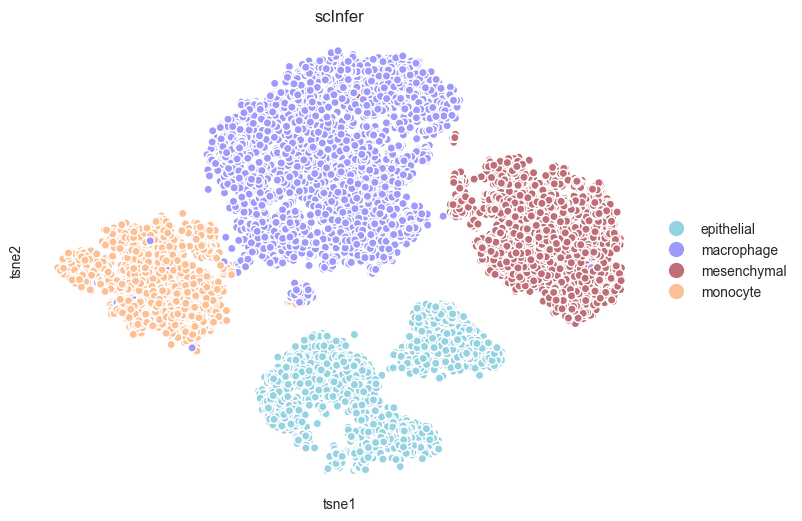

In [64]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# 合并数据用于 t-SNE 绘图  
data = rna_prt_ann.obs.merge(  
    pd.DataFrame(  
        rna_prt_ann.obsm['X_tsne'],   
        columns=['tsne1', 'tsne2'],   
        index=rna_prt_ann.obs_names  
    ),   
    how='left',   
    left_index=True,   
    right_index=True  
)  
df = data  
# 定义celltype的自定义颜色调色板  
custom_palette = {  
    'epithelial': '#96d3e2',  
    'macrophage': '#9e9afb',  
    'mesenchymal': '#bf6e75',
    'monocyte': '#fdc094'
 
}  
plt.figure(figsize=(8, 6))  

# edge_color = edge_color_dict.get('scseq', 'white')  # 默认使用黑色边缘  
sns.scatterplot(  
    data=df,  
    x='tsne1',   
    y='tsne2',   
    hue='celltype',   
    palette=custom_palette,   
    markers=True,   
    alpha=1,   
    # edgecolor=edge_color,   
    linewidth=1  # 设置边缘宽度以区分  
)  

# 去除灰色背景和横纵坐标刻度  
plt.gca().set_facecolor('white')  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.gca().spines['left'].set_visible(False)  
plt.gca().spines['bottom'].set_visible(False)  

# 去除 x 轴和 y 轴的刻度线和刻度标签  
plt.gca().set_xticks([])  
plt.gca().set_yticks([])  

# 添加图例和标签  
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)  
plt.xlabel('tsne1')  
plt.ylabel('tsne2')  
plt.title('scInfer')  
plt.gca().tick_params(left=False, bottom=False)  
# plt.savefig('./data/figure/rna_and_prt_scatter_breast.jpg', dpi=300)
# 显示图形  
plt.show()

In [65]:
rna_prt_analysis_ann = rna_prt_ann.copy()
sc.pp.neighbors(rna_prt_analysis_ann, n_neighbors=15, n_pcs=50)
sc.tl.leiden(rna_prt_analysis_ann, resolution=0.3)

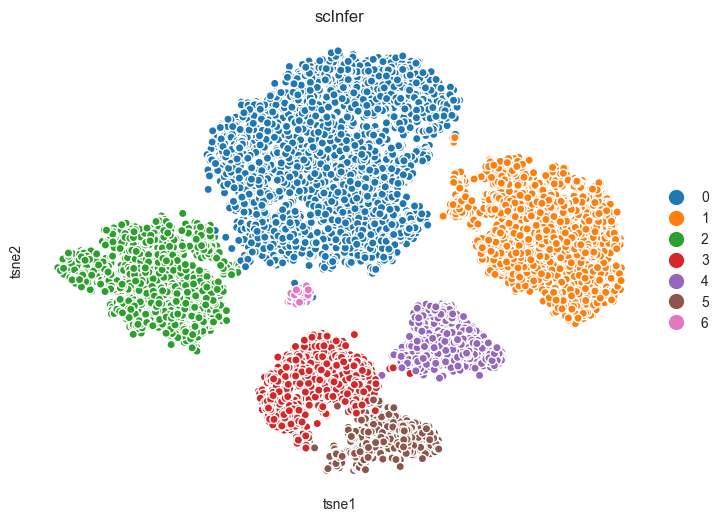

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 合并数据用于 t-SNE 绘图  
data = rna_prt_analysis_ann.obs.merge(
    pd.DataFrame(
        rna_prt_ann.obsm['X_tsne'],
        columns=['tsne1', 'tsne2'],
        index=rna_prt_ann.obs_names
    ),
    how='left',
    left_index=True,
    right_index=True
)
df = data
# # 定义celltype的自定义颜色调色板  
# custom_palette = {  
#     'epithelial': '#96d3e2',  
#     'macrophage': '#9e9afb',  
#     'mesenchymal': '#bf6e75',
#     'monocyte': '#fdc094'
#  
# }  
plt.figure(figsize=(8, 6))

# edge_color = edge_color_dict.get('scseq', 'white')  # 默认使用黑色边缘  
sns.scatterplot(
    data=df,
    x='tsne1',
    y='tsne2',
    hue='leiden',
    # palette=custom_palette,   
    markers=True,
    alpha=1,
    # edgecolor=edge_color,   
    linewidth=1  # 设置边缘宽度以区分  
)

# 去除灰色背景和横纵坐标刻度  
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# 去除 x 轴和 y 轴的刻度线和刻度标签  
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# 添加图例和标签  
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.title('scInfer')
plt.gca().tick_params(left=False, bottom=False)
# plt.savefig('./data/figure/breast_rna_prt_cluster.jpg', dpi=300)
plt.show()

In [67]:
rna_prt_analysis_ann.obs[rna_prt_analysis_ann.obs['leiden'] == '3'][['celltype_minor', 'celltype_major','celltype']].value_counts().to_frame('count').assign(percentage=lambda x: x['count'] / x['count'].sum() * 100)

,,,count,percentage
celltype_minor,celltype_major,celltype,,
Luminal Progenitors,Normal Epithelial,epithelial,1249,92.587102
Mature Luminal,Normal Epithelial,epithelial,88,6.523351
Myoepithelial,Normal Epithelial,epithelial,12,0.889548


In [68]:
rna_prt_analysis_ann.obs[rna_prt_analysis_ann.obs['leiden'] == '4'][['celltype_minor', 'celltype_major','celltype']].value_counts().to_frame('count').assign(percentage=lambda x: x['count'] / x['count'].sum() * 100)

,,,count,percentage
celltype_minor,celltype_major,celltype,,
Myoepithelial,Normal Epithelial,epithelial,1000,99.403579
Luminal Progenitors,Normal Epithelial,epithelial,4,0.397614
Macrophage,Myeloid,macrophage,1,0.099404
Mature Luminal,Normal Epithelial,epithelial,1,0.099404


In [69]:
rna_prt_analysis_ann.obs[rna_prt_analysis_ann.obs['leiden'] == '5'][['celltype_minor', 'celltype_major','celltype']].value_counts().to_frame('count').assign(percentage=lambda x: x['count'] / x['count'].sum() * 100)

,,,count,percentage
celltype_minor,celltype_major,celltype,,
Mature Luminal,Normal Epithelial,epithelial,834,98.002350
Luminal Progenitors,Normal Epithelial,epithelial,15,1.762632
Myoepithelial,Normal Epithelial,epithelial,2,0.235018
